<a href="https://colab.research.google.com/github/KevinW824/CSE-144-Applied-Machine-Learning/blob/main/Summer_21_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Assignment 5

**DUE: Sunday July 24, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Bowen Wang"
STUDENT_ID = "bwang93"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Question 1 Bitcoin price Prediction

Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$63,729.5 per bitcoin. Since reaching it's high, the price has dropped by nearly a half. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent neural network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1JbrxeSqazKn-WjizVDPG9VvhkXVG--D-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [5]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [6]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

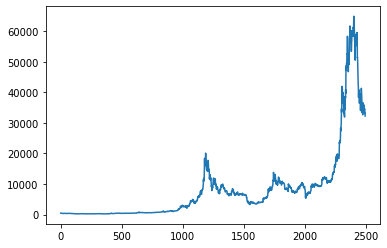

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

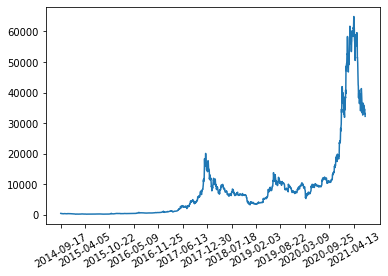

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data preprocessing (5 points)

In this section you will preprocess the in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [9]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = data.iloc[:, 2:3].to_numpy()### YOUR CODE HERE ###
data_high

array([[  468.174011],
       [  456.859985],
       [  427.834991],
       ...,
       [33061.398438],
       [33159.640625],
       [32218.40625 ]])


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [10]:
from sklearn.preprocessing import MinMaxScaler
### YOUR CODE HERE ###
scaler = MinMaxScaler()### YOUR CODE HERE ###

data_normalized = scaler.fit_transform(data_high)### YOUR CODE HERE ###
data_normalized

array([[0.00396655],
       [0.00379155],
       [0.00334261],
       ...,
       [0.50810476],
       [0.50962433],
       [0.49506572]])

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [11]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [55]:
# Choose the number of time steps that the model "looks back"
time_steps = 7### YOUR CODE HERE ###

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
X, y = create_dataset(data_normalized, time_steps)
X = np.reshape(X, (2494 - time_steps, time_steps))
y = np.reshape(y, (2494 - time_steps,))


In [56]:
# Check the shape of your dataset; should be (2495-time_steps-1, time_steps) and (2495-time_steps-1,)
print(X.shape, y.shape)

(2487, 7) (2487,)


### Part b) Data Partitioning (5 points)

Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [57]:
### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [58]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Part c) RNN Model (20 points)
---

In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary:

In [66]:
# Build your model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
### YOUR CODE HERE ###
model = Sequential()

# Adding the input layer and the LSTM layer
model.add(LSTM(4))

# Adding the output layer
model.add(Dense(1))

loss = tf.keras.losses.MeanSquaredError()### YOUR CODE HERE ###

opt = tf.keras.optimizers.Adam()### YOUR CODE HERE ###

metrics = [tf.keras.metrics.MeanSquaredError()]### YOUR CODE HERE ###

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

In [67]:

batchsize = 32### YOUR CODE HERE ###

epochs =  5### YOUR CODE HERE ###

# Fit model
history = model.fit(X_train, 
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2
                    )### YOUR CODE HERE ###


Epoch 1/5
50/50 [==============================] - 3s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/5
50/50 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/5
50/50 [==============================] - 0s 3ms/step - loss: 5.4581e-04 - mean_squared_error: 5.4581e-04 - val_loss: 6.5631e-04 - val_mean_squared_error: 6.5631e-04
Epoch 5/5
50/50 [==============================] - 0s 3ms/step - loss: 1.8994e-04 - mean_squared_error: 1.8994e-04 - val_loss: 2.1014e-04 - val_mean_squared_error: 2.1014e-04


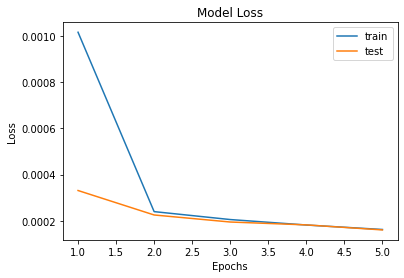

In [18]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot([x+1 for x in range(epochs)], history.history['loss'])
plt.plot([x+1 for x in range(epochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part d) More Advanced RNN Model (20 points)
---
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [68]:
# Build your model

### YOUR CODE HERE ###
model_tuned = Sequential()

# Adding the input layer and the LSTM layer
model_tuned.add(LSTM(10, return_sequences=True))
model_tuned.add(LSTM(10, return_sequences=True))

# Adding the output layer
model_tuned.add(Dense(1))

loss = tf.keras.losses.MeanSquaredError()### YOUR CODE HERE ###

opt = tf.keras.optimizers.Adam()### YOUR CODE HERE ###

metrics = [tf.keras.metrics.MeanSquaredError()]### YOUR CODE HERE ###

model_tuned.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

In [69]:
batchsize = 64### YOUR CODE HERE ###

epochs = 10### YOUR CODE HERE ###

# Fit model
history = model_tuned.fit(X_train, 
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2
                    )### YOUR CODE HERE ###


Epoch 1/10
25/25 [==============================] - 5s 40ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 5.7603e-04 - mean_squared_error: 5.7603e-04 - val_loss: 4.9718e-04 - val_mean_squared_error: 4.9718e-04
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 1.3135e-04 - mean_squared_error: 1.3135e-04 - val_loss: 1.0905e-04 - val_mean_squared_error: 1.0905e-04
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 7.5470e-05 - mean_squared_error: 7.5470e-05 - val_loss: 1.0305e-04 - val_mean_squared_error: 1.

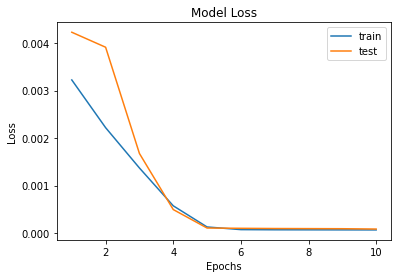

In [70]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot([x+1 for x in range(10)], history.history['loss'])
plt.plot([x+1 for x in range(10)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part e): Looking at the Predictions (10 points)
---

Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help? Does your model use dropout or batchnormalization?

**Note:** Your model is trained on normalized data. Inorder to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
### YOUR CODE HERE ###

My final model lands on around 8.76e-05 for validation loss.\
While I was changing the hyperparameters, I found that adding LSTM layer and increase number of units decrease losses but adding dropout layers increase losses a lot.\
I started with 30 look back days. Then I change to 14, 7 and 3. I figured having a smaller look back days will make the losses decrease faster through each epoch. 30 look back days have a relatively smooth loss curve.\
I finalized on 7 look back days with starts with a slightly higher loss but decrease very fast, end up with the smallest validation loss. If the look back days become too small, model performance with actually be worse. 

## Question 3: Denoising Autoencoder


You will now build a simple denoising autoencoder using the MNIST Fashion dataset. Begin by getting our imports and downloading the dataset.

In [71]:
import os
import numpy as np
from keras.datasets import fashion_mnist

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
rn.seed(123)
np.random.seed(seed=123)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
%matplotlib inline

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Plot some of the images from x_test
fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

As expected, we have the MNIST Fashion dataset. Now, noise will be added to the images in boath x_train and x_test. Then, we will plot some of the noisy images from x_train. This may take a little while.

In [ ]:
def corrupt_pixel(image):
    """selects a certain number of pixels (between 50 and 100) and changes their value to 255"""
    num_pixels = np.random.randint(50,100)
    img = image.copy()

    for i in range(num_pixels):
        cell = np.random.randint(0,28,size = 2)
        img[cell[0]][cell[1]] = np.random.randint(125,255)
    return img

In [ ]:
# corrupt the images
x_train_noisy = [] #x_train with noise added
for image in x_train:
    x_train_noisy.append(corrupt_pixel(image))

x_test_noisy = [] #x_test with noise added
for image in x_test:
    x_test_noisy.append(corrupt_pixel(image))

In [ ]:
# Replot some of the test images with noise added
rn.seed(123)
np.random.seed(seed=123)

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test_noisy[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

We can now see that we have corrupted the images. We will now build a denoising autoencoder to hopefully remove some of the noise. First, data will be normalize the data and an extra dimension will be added to the images.

In [ ]:
# Scale X_train to 255. which is max
x_train  = np.array(x_train)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train = x_train.reshape(len(x_train),28,28,1)

# Scale X_test to 255. which is max
x_test  = np.array(x_test)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test = x_test.reshape(len(x_test),28,28,1)

# Scale X_train to 255. which is max
x_train_noisy  = np.array(x_train_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy),28,28,1)

# Scale X_test to 255. which is max
x_test_noisy  = np.array(x_test_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy),28,28,1)

### Part a) Build the autoencoder (20 points)


 Now we will build the autoencoder. You are free to build an architecture of your choice. Again, You are welcome to use any code from previous class exercises, section handouts, and lectures. Build your model below and comment on your model's architecture. Do you have convolution layers, or a fully connected encoder, dropout and/or batch normalization, what kind of activation did you use? It may help to think about the encoder/decoder architectures simultaneously.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.


In [ ]:
# Build your model

### YOUR CODE HERE ###

[YOUR ANSWER HERE]

### Part b) Training the autoencoder (10 points)
Write code that trains your autoencoder. Use mean square error as your loss, choose an optimizer of your choice. Be

Plot the training curve as well.

In [ ]:
# Compile your model

### YOUR CODE HERE ###

# Train the autoencoder

### YOUR CODE HERE ###


In [ ]:
# Plot the training curve for loss

### YOUR CODE HERE ###


### Part c) Plot images and comment (10 points)

Plot images some of the "denoised" images from the test set. Comment on how your model has performed. Was your model able to denoise the image successfully? Is there anything unexpected results about the images? MSE error is known to smooth an image too much, did your model suffere the same result?

In [ ]:
# Plot images some of the "denoised" images from the test set

### YOUR CODE HERE ###


[YOUR ANSWER HERE]